In [2]:
##############################
# IMPORT
##############################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression , mutual_info_classif



pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)






##############################
# FUNCTIONS
##############################

def apply_pca(X, standardize=True, n_components=None):
    """
    Apply Principal Component Analysis (PCA) to the input data.

    This function standardizes the input data (optional) and performs PCA to reduce
    dimensionality. It returns the PCA object, a DataFrame with transformed data, and
    a DataFrame with loadings for each PCA component.

    Parameters:
    -----------
    X : pandas.DataFrame
        The input DataFrame containing the features to be analyzed.

    standardize : bool, optional (default=True)
        If True, standardize the input data by subtracting the mean and dividing by the
        standard deviation for each feature.

    n_components : int or None, optional (default=None)
        Number of components to keep. If None, all components are kept.

    Returns:
    --------
    pca : sklearn.decomposition.PCA
        The PCA object that contains information about the PCA transformation.

    X_pca : pandas.DataFrame
        Transformed data with principal components as columns.

    loadings : pandas.DataFrame
        Loadings matrix, indicating the contribution of each original feature to each
        principal component.

    Example:
    --------
    pca, X_pca, loadings = apply_pca(X, standardize=True, n_components=3)
    """
    if X.isnull().sum().sum() != 0:
        print(f"Input dataframe cannot contain any NaN value, but it has {X.isnull().sum().sum()} NaN values.")
        return
    X.replace(np.inf, np.nan, inplace=True)
    max_values = X.max()
    X.fillna(max_values, inplace=True)
    
    X.replace(-np.inf, np.nan, inplace=True)
    min_values = X.min()
    X.fillna(min_values, inplace=True)

    # Standardize
    if standardize:
        cols = X.columns
        X = StandardScaler().fit_transform(X)
        X = pd.DataFrame(X, columns=cols)
    
    # Create principal components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )

    return pca, X_pca, loadings






def plot_pca_variance(pca, width=10, dpi=120):
    """
    Plot Explained Variance and Cumulative Variance graphs for Principal Component Analysis (PCA).

    This function creates two subplots in a single figure. The first subplot displays the
    percentage of explained variance for each principal component, while the second subplot
    shows the cumulative explained variance as more components are added.

    Parameters:
    -----------
    pca : sklearn.decomposition.PCA
        The PCA object obtained from applying PCA to the data.

    width : int, optional (default=10)
        Width of the figure in inches.

    dpi : int, optional (default=120)
        Dots per inch for figure resolution.

    Returns:
    --------
    None

    Example:
    --------
    pca, X_pca, loadings = apply_pca(X, standardize=True, n_components=3)
    plot_pca_variance(pca)
    """

    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, round(10*max(evr)+0.5)/10)
    )
    axs[0].title.set_weight('bold')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[0].set_xticks(grid)
    axs[0].set_xticklabels(grid)

    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(grid, cv, "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.01)
    )
    axs[1].title.set_weight('bold')
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[1].set_xticks(grid)
    axs[1].set_xticklabels(grid)

    # Cumulative variance value on the 2nd plot
    axs[1].annotate(f'CV={cv[-1]:.3f}', (grid[-1], cv[-1]), textcoords="offset points", xytext=(-15,-10), ha='center')

    # Set up figure
    fig.set(figwidth=width, dpi=dpi)






def plot_mi_scores(X, y, mode="regression", p: int = None):
    """
    Plot Mutual Information (MI) Scores for feature selection.

    This function calculates and displays Mutual Information (MI) Scores for each
    independent feature with respect to the target variable. MI measures the
    dependency between two random variables and is useful for feature selection.

    Parameters:
    -----------
    X : pandas.DataFrame
        The input DataFrame containing the independent features.

    y : array-like
        The target variable.

    mode : str, optional (default="regression")
        The mode of MI Score calculation. Choose from 'regression' or 'classification'.

    p : int or None, optional (default=None)
        Number of top features to display with the highest MI Scores. If None,
        all features are displayed. Should be an integer greater than or equal to 1.

    Returns:
    --------
    None

    Example:
    --------
    plot_mi_scores(X, y, mode="classification", p=5)
    """

    if p is not None:
        if p < 1 or p != int(p):
            print(f"'p' must be at least 1 and an integer.")
            return
        p = int(p)

    if mode not in ['regression', 'classification']:
        print("'mode' parameter can be equal to 'regression' or 'classification'.")
        return
    
    if X.isnull().sum().sum() != 0:
        print(f"Input dataframe cannot contain any NaN value, but it has {X.isnull().sum().sum()} NaN values.")
        return
    
    X = X.copy()
    X.replace(np.inf, np.nan, inplace=True)
    max_values = X.max()
    X.fillna(max_values, inplace=True)
    X.replace(-np.inf, np.nan, inplace=True)
    min_values = X.min()
    X.fillna(min_values, inplace=True)
    
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    if mode == 'regression':
        scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    else:
        scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    scores = pd.Series(scores, name="MI Scores", index=X.columns)
    scores = scores.sort_values(ascending=True)
    
    if p is not None:
        scores = scores[-p:]

    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.ylabel("Independent Features")
    plt.title("Mutual Information Scores", fontsize=30)
    plt.show(block=True)






def encode_scale_concate(x1, x2, columns: list, standardize=True, encoder='onehot'):
    """
    Standardize and encode specified columns in x2 DataFrame, then concatenate them with x1.

    This function takes two DataFrames, x1 and x2, and performs the following operations:
    1. Encodes specified columns in x2 using one-hot encoding or label encoding.
    2. Optionally standardizes the encoded columns.
    3. Concatenates the resulting columns from x2 with x1 on a column-by-column basis.

    Parameters:
    -----------
    x1 : pandas.DataFrame
        The first DataFrame to which columns will be added.

    x2 : pandas.DataFrame
        The second DataFrame from which columns will be encoded and scaled.

    columns : list
        List of column names in x2 to be encoded and optionally standardized.

    standardize : bool, optional (default=True)
        If True, standardize the encoded columns.

    encoder : str, optional (default='onehot')
        The encoding method to use for categorical columns. Choose from 'onehot', 'label',
        or None. 'onehot' performs one-hot encoding, 'label' performs label encoding,
        and None skips encoding.

    Returns:
    --------
    x : pandas.DataFrame
        The resulting DataFrame with concatenated and processed columns.

    Example:
    --------
    x_combined = encode_scale_concate(x1, x2, columns=categorical_columns, standardize=True)
    """

    if encoder not in ['onehot', 'label', None]:
        print("'encoder' parameter can be equal to 'onehot', 'label', or None.")
        return

    if encoder == 'onehot':
        add_df = pd.get_dummies(x2[columns], drop_first=True)
    elif encoder == 'label':
        add_df = x2[columns].copy()
        label_encoder = LabelEncoder()
        for col in columns:
            add_df[col] = label_encoder.fit_transform(add_df[col])
    else:
        add_df = x2

    if standardize:
        col_names = add_df.columns
        add_df = StandardScaler().fit_transform(add_df)
        add_df = pd.DataFrame(add_df, columns=col_names)

    x = pd.concat([x1.reset_index(drop=True), add_df.reset_index(drop=True)], axis=1)
    return x






def visualize_pca(pca_df, target, figsize=(12, 10)):
    """
    Visualizes PCA components.

    Args:
        pca_df (DataFrame): a dataFrame consisting of 2 or 3 PCA components.
        target (ndarray or Series): Categorical or numeric target data set.
        figsize (tuple): (width of plot, height of plot).

    Returns:
        None
    """
    label_encoder = None
    
    if not np.issubdtype(target.dtype, np.number):
        # If target is non-numeric, apply label encoding.
        label_encoder = LabelEncoder()
        target = label_encoder.fit_transform(target)
    
    if pca_df.shape[1] == 2:
        # 2D Visualization
        plt.figure(figsize=figsize)
        scatter = plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=target, cmap='viridis', marker='o')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title("2D PCA Visualization", fontweight="bold", fontsize=16)
        plt.colorbar(scatter, label='Target')
        
        # Add legends for non-numeric targets
        if label_encoder is not None:
            unique_targets = np.unique(target)
            handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(k)), markerfacecolor=scatter.cmap(scatter.norm(k)), markersize=10, label=v) for k, v in zip(unique_targets, label_encoder.classes_)]
            plt.legend(handles=handles)
        
        plt.show()
    elif pca_df.shape[1] == 3:
        # 3D Visualization
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], pca_df.iloc[:, 2], c=target, cmap='viridis', marker='o')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title("3D PCA Visualization", fontweight="bold", fontsize=16)
        fig.colorbar(scatter, label='Target')
        
        # Add legends for non-numeric targets
        if label_encoder is not None:
            unique_targets = np.unique(target)
            handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(k)), markerfacecolor=scatter.cmap(scatter.norm(k)), markersize=10, label=v) for k, v in zip(unique_targets, label_encoder.classes_)]
            plt.legend(handles=handles)
        
        plt.show()
    else:
        print("Unsupported number of PCA components. 2 or 3 components are required.")




def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [3]:
# importing or loading the dataset
# import data
# we have data from two years in a monthly resolution and a grid with dimensions 1442x1021
data_2009 = pd.read_pickle('../../data/2009_df.pkl')
data_2018 = pd.read_pickle('../../data/2018_df.pkl')

# Perform one-hot encoding
#one_hot_encoded = pd.get_dummies(data_2018['time_counter'], prefix='', prefix_sep='')
#one_hot_encoded = one_hot_encoded.astype(int)

# Combine the one-hot encoding with the original DataFrame (optional)
#data_2018 = pd.concat([data_2018,one_hot_encoded], axis=1)
data_2018=data_2018[data_2018['tmask'] == 1]
data_2018 = data_2018.sample(frac=1)
data_2018=data_2018[:1000000]
df = data_2018[['co2flux','SST','SAL','ice_frac','mixed_layer_depth','heat_flux_down','water_flux_up','stress_X','stress_Y','currents_X','currents_Y','nav_lat','nav_lon','time_counter']]#,'2018-01-16 12:00:00','2018-02-15 00:00:00','2018-03-16 12:00:00','2018-04-16 00:00:00','2018-05-16 12:00:00','2018-06-16 00:00:00','2018-07-16 12:00:00','2018-08-16 12:00:00','2018-09-16 00:00:00','2018-10-16 12:00:00','2018-11-16 00:00:00','2018-12-16 12:00:00',]]

In [4]:
#Let's see the dataframe.
print(df.head())

           co2flux        SST        SAL  ice_frac  mixed_layer_depth  heat_flux_down  water_flux_up  stress_X  stress_Y  currents_X  currents_Y    nav_lat     nav_lon        time_counter
92892     2.861856   1.183391  31.830706  0.000000          12.839149      103.956261       0.000049 -0.021500  0.008003   -0.014121    0.005110 -76.726501 -154.500000 2018-01-16 12:00:00
1596894  -0.104905  -1.646386  34.270424  0.959791         120.346451      -57.995789       0.000002 -0.028550  0.147405    0.004461   -0.006483 -70.695435  175.250000 2018-07-16 12:00:00
3969781   1.508570   4.449408  34.028858  0.000000          65.154396       52.019707      -0.000005  0.157528  0.023708    0.085163    0.100526 -55.635715 -138.000000 2018-02-15 00:00:00
6922091   0.125660  23.630800  35.892506  0.000000          18.398500       96.313004       0.000023 -0.084095  0.021916   -0.017437    0.027662 -23.785791   82.750000 2018-12-16 12:00:00
10837226  3.169971  18.554642  34.665695  0.000000          

In [5]:
#Numerical columns
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
print(num_cols)

['co2flux', 'SST', 'SAL', 'ice_frac', 'mixed_layer_depth', 'heat_flux_down', 'water_flux_up', 'stress_X', 'stress_Y', 'currents_X', 'currents_Y', 'nav_lat', 'nav_lon', 'time_counter']


In [6]:
#Nonnumerical columns
non_num_cols = [col for col in df.columns if col not in num_cols]
print(non_num_cols)

[]


In [7]:
x = df.drop(['co2flux'], axis=1)
y = df['co2flux']

label_encoder(x,'time_counter')

#Label encoded version
print(x.head())

                SST        SAL  ice_frac  mixed_layer_depth  heat_flux_down  water_flux_up  stress_X  stress_Y  currents_X  currents_Y    nav_lat     nav_lon  time_counter
92892      1.183391  31.830706  0.000000          12.839149      103.956261       0.000049 -0.021500  0.008003   -0.014121    0.005110 -76.726501 -154.500000             0
1596894   -1.646386  34.270424  0.959791         120.346451      -57.995789       0.000002 -0.028550  0.147405    0.004461   -0.006483 -70.695435  175.250000             6
3969781    4.449408  34.028858  0.000000          65.154396       52.019707      -0.000005  0.157528  0.023708    0.085163    0.100526 -55.635715 -138.000000             1
6922091   23.630800  35.892506  0.000000          18.398500       96.313004       0.000023 -0.084095  0.021916   -0.017437    0.027662 -23.785791   82.750000            11
10837226  18.554642  34.665695  0.000000          54.202511      -24.229004       0.000051 -0.035124 -0.057267    0.015345   -0.012007  30.4

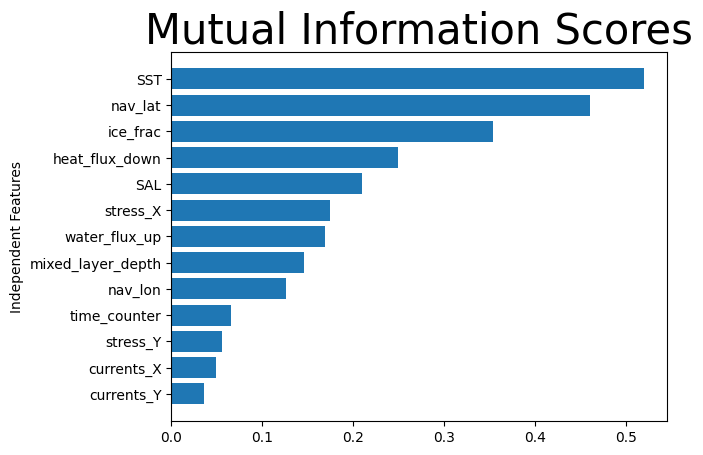

In [8]:

#See MI Scores
plot_mi_scores(x,y,mode="regression", p=None)
# IMAGE IS BELOW (mi_scores_01.png)

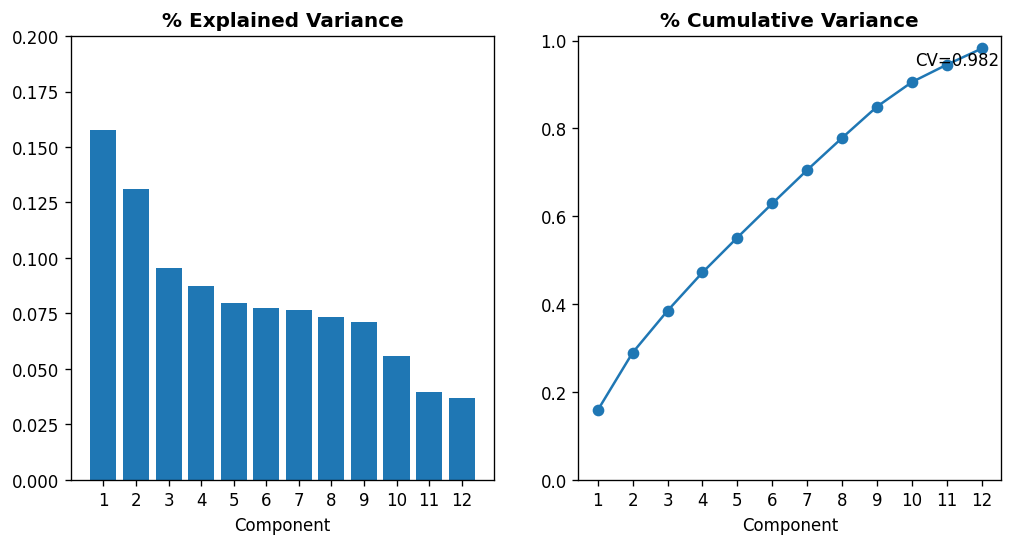

In [9]:
pca, x_pca, loadings = apply_pca(x, standardize=True, n_components=12)
plot_pca_variance(pca)